### Setup

In [14]:
from openai import OpenAI
from tqdm import tqdm
from tvalmetrics import RagScoresCalculator
import os

In [15]:
# Load questions from qa_pairs.json
import json
qa_pairs = []
with open('qa_pairs.json', 'r') as qa_file:
    qa_pairs = json.load(qa_file)

question_list = [qa_pair['question'] for qa_pair in qa_pairs]
print("Questions:\n" + "\n".join(question_list[:4]))

print()

answer_list = [qa_pair['answer'] for qa_pair in qa_pairs]
print("Answers:\n" + "\n".join(question_list[:4]))

Questions:
What key components are necessary to create a technology hub according to Paul Graham?
What is the influence of geography on where great cities historically developed, and how has that changed in modern times?
How are people classified according to their degree and aggressiveness of conformism?
What is the main danger of restricting the discussion of certain ideas?

Answers:
What key components are necessary to create a technology hub according to Paul Graham?
What is the influence of geography on where great cities historically developed, and how has that changed in modern times?
How are people classified according to their degree and aggressiveness of conformism?
What is the main danger of restricting the discussion of certain ideas?


In [16]:
score_calculator = RagScoresCalculator(
    model="gpt-4-1106-preview",
    answer_similarity_score=True,
)

### Haystack

#### Setup

In [11]:
from haystack import Pipeline
from haystack.document_stores import InMemoryDocumentStore
from haystack.utils import add_example_data
from haystack.nodes import EmbeddingRetriever, PromptNode, PromptTemplate, AnswerParser

def get_haystack():
    document_store = InMemoryDocumentStore(similarity="dot_product", embedding_dim=1536)
    add_example_data(document_store, "paul_graham_essays")
    retriever = EmbeddingRetriever(
        document_store=document_store,
        batch_size=8,
        embedding_model="text-embedding-ada-002",
        api_key=os.environ["OPENAI_API_KEY"],
        max_seq_len=1536,
        progress_bar=False
    )
    document_store.update_embeddings(retriever)
    prompt_template = PromptTemplate(
        prompt="deepset/question-answering",
        output_parser=AnswerParser(),
    )
    prompt_node = PromptNode(
        model_name_or_path="gpt-4-1106-preview",
        api_key=os.environ["OPENAI_API_KEY"],
        default_prompt_template=prompt_template,
        max_length=2048
    )
    query_pipeline = Pipeline()
    query_pipeline.add_node(component=retriever, name="retriever", inputs=["Query"])
    query_pipeline.add_node(component=prompt_node, name="prompt_node", inputs=["retriever"])
    return query_pipeline

C:\Users\EthanPhilpott\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-30 16:39:34,671	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [12]:
haystack_pipeline = get_haystack()

Preprocessing: 100%|██████████| 212/212 [00:00<00:00, 286.45docs/s]
Documents Processed: 10000 docs [04:08, 40.29 docs/s]           


In [15]:
def get_haystack_response(query):
    haystack_response = haystack_pipeline.run(query=query)
    return haystack_response['answers'][0].answer

#### Testing

In [16]:
print(get_haystack_response(
    "What was Airbnb's monthly financial goal to achieve ramen profitability during their time at Y Combinator?"
))

Airbnb's monthly financial goal to achieve ramen profitability during their time at Y Combinator was $4000 a month.


In [17]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Using ThreadPoolExecutor to process questions in parallel
with ThreadPoolExecutor(max_workers=10) as executor:
    # Map the process_question function to each question in the list
    haystack_responses = list(tqdm(executor.map(get_haystack_response, question_list), total=len(question_list)))

  0%|          | 0/55 [00:00<?, ?it/s]

100%|██████████| 55/55 [02:12<00:00,  2.41s/it]


In [18]:
openai_batch_scores = score_calculator.score_batch(
    question_list=question_list,
    reference_answer_list=answer_list,
    llm_answer_list=haystack_responses,
)

In [19]:
openai_scores_df = openai_batch_scores.to_dataframe()
# Remove overall_score column since we are only using one stat
openai_scores_df = openai_scores_df.drop(columns=['overall_score'])
openai_scores_df.describe()

,answer_similarity_score
count,55.000000
mean,4.400000
std,0.914897
min,2.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [1]:
# import from csv
import pandas as pd
openai_scores_df = pd.read_csv('haystack.csv')

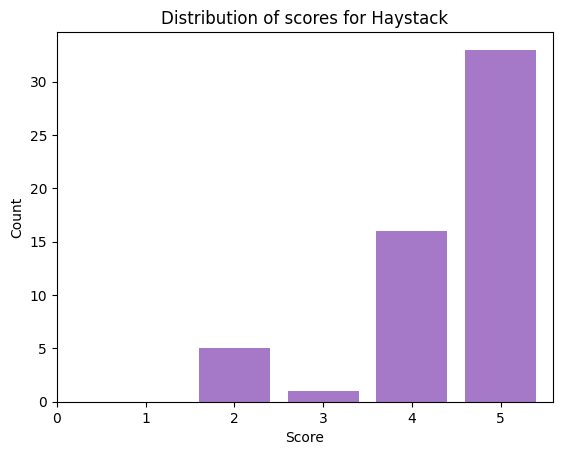

In [7]:
import matplotlib.pyplot as plt
category_counts = openai_scores_df['answer_similarity_score'].value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for Haystack')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()

### LangChain

#### Setup

In [17]:
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores.chroma import Chroma

def get_langchain_retriever():
    loader = DirectoryLoader('paul_graham_essays', show_progress=True)
    docs = loader.load()
    text_splitter = RecursiveCharacterTextSplitter()
    split_docs = text_splitter.split_documents(docs)
    embeddings = OpenAIEmbeddings()
    db = Chroma.from_documents(split_docs, embeddings)
    return db.as_retriever()

In [18]:
def format_docs(docs):
    return "\n\n".join([d.page_content for d in docs])

In [19]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

def get_langchain():
    template = """Answer the question based only on the following context:

    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    model = ChatOpenAI(model_name="gpt-4-1106-preview")
    retriever = get_langchain_retriever()
    chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    return chain

In [20]:
langchain_pipeline = get_langchain()

100%|██████████| 212/212 [00:12<00:00, 17.52it/s]


In [21]:
print(langchain_pipeline.invoke(
    "What was Airbnb's monthly financial goal to achieve ramen profitability during their time at Y Combinator?"
))

Airbnb's monthly financial goal to achieve ramen profitability during their time at Y Combinator was $4000 a month.


In [22]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Using ThreadPoolExecutor to process questions in parallel
with ThreadPoolExecutor(max_workers=10) as executor:
    # Map the process_question function to each question in the list
    langchain_responses = list(tqdm(executor.map(langchain_pipeline.invoke, question_list), total=len(question_list)))

100%|██████████| 55/55 [01:14<00:00,  1.35s/it]


In [23]:
openai_batch_scores = score_calculator.score_batch(
    question_list=question_list,
    reference_answer_list=answer_list,
    llm_answer_list=langchain_responses,
)

In [26]:
openai_scores_df = openai_batch_scores.to_dataframe()
# Remove overall_score column since we are only using one stat
openai_scores_df = openai_scores_df.drop(columns=['overall_score'])
openai_scores_df.describe()

,answer_similarity_score
count,55.000000
mean,4.000000
std,1.452966
min,0.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [28]:
# Save to csv
openai_scores_df.to_csv('langchain.csv')

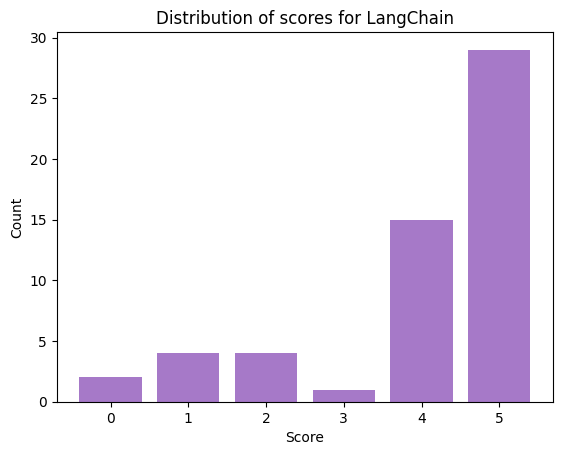

In [27]:
import matplotlib.pyplot as plt
category_counts = openai_scores_df['answer_similarity_score'].value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for LangChain')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()

In [79]:
# Make graph comparing langchain and haystack score distributions
import matplotlib.pyplot as plt
import pandas as pd

# import from csv
haystack_scores = pd.read_csv('haystack.csv')
langchain_scores = pd.read_csv('langchain.csv')

# Combine the two dataframes with answer_similarity_score. Change names of columns to distinguish between the two\
haystack_scores = haystack_scores.rename(columns={'answer_similarity_score': 'Haystack'})
langchain_scores = langchain_scores.rename(columns={'answer_similarity_score': 'LangChain'})
combined_scores = pd.concat([haystack_scores['Haystack'], langchain_scores['LangChain']], axis=1)

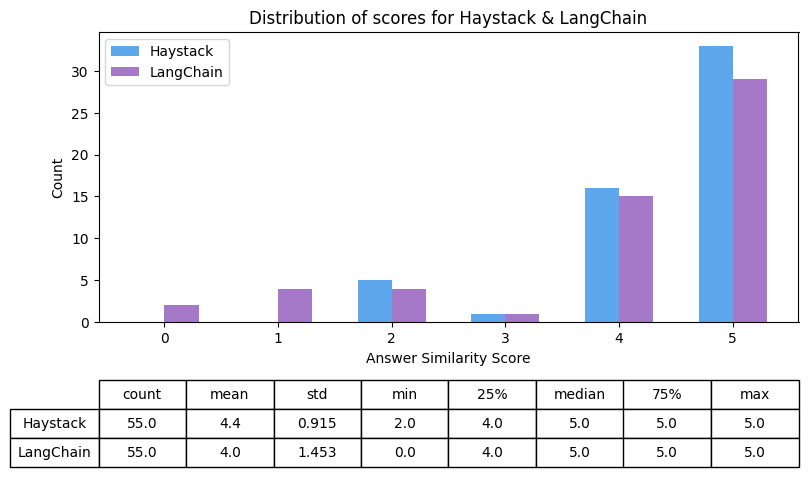

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Position of bars on x-axis
ind = np.arange(6)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3

haystack_counts = combined_scores['Haystack'].value_counts().reindex([0,1,2,3,4,5], fill_value=0)
plt.bar(haystack_counts.index, haystack_counts.values, width, label="Haystack", color="#5EA7EC")

langchain_counts = combined_scores['LangChain'].value_counts().reindex([0,1,2,3,4,5], fill_value=0)
plt.bar(langchain_counts.index + width, langchain_counts.values, width, label="LangChain", color="#A679C8")

plt.title('Distribution of scores for Haystack & LangChain')
plt.xlabel('Answer Similarity Score')
plt.ylabel('Count')

# Remove all scores except whole numbers
plt.xticks(ind + width / 2, range(0, 6, 1))

plt.legend(loc='best')

# Rounding the descriptive statistics to 3 significant figures
statistics_df = combined_scores.describe()
# Change 50% to 50% (median)
statistics_df = statistics_df.rename(index={'50%': 'median'})
rounded_statistics_df = statistics_df.round(3)

# Transposing the descriptive statistics table for horizontal display
rounded_statistics_df = rounded_statistics_df.T

# Adding the table below the histogram
table = plt.table(cellText=rounded_statistics_df.values,
                  colWidths=[0.1] * len(rounded_statistics_df.columns),
                  rowLabels=rounded_statistics_df.index,
                  colLabels=rounded_statistics_df.columns,
                  cellLoc = 'center', rowLoc = 'center',
                  loc='bottom', bbox=[0.0, -0.5, 1.0, 0.3])

plt.subplots_adjust(left=0.2, bottom=0.3)

plt.show()